# Cosmic Ray Proton Spectrum Fitting
## ATIC

In [2]:
from pylab import *
from scipy.optimize import minimize 
from scipy import interpolate

In [3]:
def Phi_onebreak(E, K, E0, alpha1, alpha2, omega1, Eb1):
    delta1 = alpha2 - alpha1
    return K * (E/E0)**(-alpha1) * (1 + (E/Eb1)**(1/omega1))**(-delta1 * omega1)

In [11]:
m_p = 0.938
data_ATIC_H = np.genfromtxt("Data/Proton/ATIC_H_data.txt")
E_ATIC = data_ATIC_H[:,1] #- m_p
flux_ATIC = data_ATIC_H[:,3] #* (E_ATIC / (E_ATIC - m_p)) # Normalize to Ek
error_ATIC = data_ATIC_H[:,4]

In [12]:
E = E_ATIC
Flux = flux_ATIC
Sigma = 2*error_ATIC

# To have the same number of degrees of freedom as in (Lipari & Vernetto, 2019), lower energy must be 4.5e1 instead of 1e2 GeV
index = np.where(np.logical_and(E>=4.5e1, E<=1e5))
E = E[index]; Flux = Flux[index]; Sigma = Sigma[index]

# Check number of degrees of freedom
print('# data points used:', 15)
print('# actual data points:', len(Flux))

def Chi_ATIC(parameters):
    K, alpha1, alpha2, omega1, Eb1 = parameters
    Phi_model = Phi_onebreak(E, K, 0.1 * 1e3, alpha1, alpha2, omega1, Eb1)
    return sum( (Phi_model - Flux)**2 / Sigma**2 ) 

# data points used: 15
# actual data points: 15


In [13]:
# Check of chi^2 with reported value
alpha1_bestfit_ATIC = 2.79
alpha2_bestfit_ATIC = 2.62
Eb1_bestfit_ATIC = 0.275 * 1e3 #GeV
omega1_bestfit_ATIC = 0.34
K_bestfit_ATIC = 4.4 * 10**(-2) #(GeV m2 s sr)-1

parameters_bestfit_ATIC = K_bestfit_ATIC, alpha1_bestfit_ATIC, alpha2_bestfit_ATIC, omega1_bestfit_ATIC, Eb1_bestfit_ATIC
print('Min chi^2 from Lipari & Vernetto:', 1.5)
print('Computed chi^2:', Chi_ATIC(parameters_bestfit_ATIC) )

Min chi^2 from Lipari & Vernetto: 1.5
Computed chi^2: 11.078225672480638


In [14]:
# Minimization of chi^2
bounds_range = ((4e-2,5e-2),(2,3),(2,3),(0.0001,1),(1e2,1e5))
output = minimize(Chi_ATIC, (K_bestfit_ATIC, alpha1_bestfit_ATIC, alpha2_bestfit_ATIC, omega1_bestfit_ATIC, Eb1_bestfit_ATIC), method='L-BFGS-B', bounds=bounds_range)
best_fit_values = output['x']

# Best fit values
print('LIPARI & VERNETTO BEST FIT VALUES:')
print('K:', round(K_bestfit_ATIC,4)); 
print('alpha_1:', round(alpha1_bestfit_ATIC,3)); print('alpha_2:', round(alpha2_bestfit_ATIC,3))
print('omega:', round(omega1_bestfit_ATIC,3))
print('E_b:', round(Eb1_bestfit_ATIC,4), 'GeV')
print('')

print('MY BEST FIT VALUES:')
print('K:', round(best_fit_values[0],3))
print('alpha_1:', round(best_fit_values[1],3)); print('alpha_2:', round(best_fit_values[2],3))
print('omega:', round(best_fit_values[3],3))
print('E_b:', round(best_fit_values[4],3), 'GeV')
print('')

min_chi = Chi_ATIC(best_fit_values)
print('chi^2_min:', round(min_chi,7))

LIPARI & VERNETTO BEST FIT VALUES:
K: 0.044
alpha_1: 2.79
alpha_2: 2.62
omega: 0.34
E_b: 275.0 GeV

MY BEST FIT VALUES:
K: 0.044
alpha_1: 2.793
alpha_2: 2.6
omega: 0.544
E_b: 274.977 GeV

chi^2_min: 1.8143285


In [15]:
def Errors_ATIC(n):
    
    alpha1 = 2.79
    alpha2 = 2.62
    Eb1 = 0.275 * 1e3 #GeV
    omega1 = 0.34
    K = 4.4 * 10**(-2) #(GeV m2 s sr)-1
    bounds_range = ((4e-2,5e-2),(2,3),(2,3),(0.0001,1),(1e2,1e5))
    output = minimize(Chi_ATIC, (K, alpha1, alpha2, omega1, Eb1), method='L-BFGS-B', bounds=bounds_range)
    best_fit_values = output['x']
    
    scan = np.zeros(500)
    fit = best_fit_values[n]
    for i in range(0, 250):
        scan[i] = fit - (fit / 1000)*i
    for j in range(250, 500):
        scan[j] = fit + (fit / 1000)*j
    scan = np.sort(scan)
    
    true_best_fit = Chi_ATIC(best_fit_values)
    chi_sqrd = np.zeros(500)
    for k in range(0, 500):
        best_fit_values[n] = scan[k]
        scan_chi = Chi_ATIC(best_fit_values)
        chi_sqrd[k] = np.abs(true_best_fit - scan_chi)
    return scan, fit, chi_sqrd

# Find value for which chi^2 is equal to one
yToFind = 5.89

# Error of normilization
scan, fit, chi_sqrd = Errors_ATIC(0)
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(scan, yreduced, s=0)
scan_interval = freduced.roots()
print('K'); print('Lower error:', fit - scan_interval[0]); print('Upper error:', scan_interval[1] - fit)

# Error of first index
scan, fit, chi_sqrd = Errors_ATIC(1)
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(scan, yreduced, s=0)
scan_interval = freduced.roots()
print('alpha1'); print('Lower error:', fit - scan_interval[0]); print('Upper error:', scan_interval[1] - fit)

#Error of second index
scan, fit, chi_sqrd = Errors_ATIC(2)
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(scan, yreduced, s=0)
scan_interval = freduced.roots()
print('alpha2'); print('Lower error:', fit - scan_interval[0]); print('Upper error:', scan_interval[1] - fit)

# Error of break energy
scan, fit, chi_sqrd = Errors_ATIC(4)
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(scan, yreduced, s=0)
scan_interval = freduced.roots()
print('Eb1'); print('Lower error:', fit - scan_interval[0]); print('Upper error:', scan_interval[1] - fit)

K
Lower error: 0.0005496615127228016
Upper error: 0.0005496713921383928
alpha1
Lower error: 0.028107856108626095
Upper error: 0.03034424461813945
alpha2
Lower error: 0.028556376122793825
Upper error: 0.035379084329724364
Eb1
Lower error: 46.029411327796254
Upper error: 59.84872069537926


omega1
Lower error: 0.15028867729497802
Upper error: 0.12852203711375842


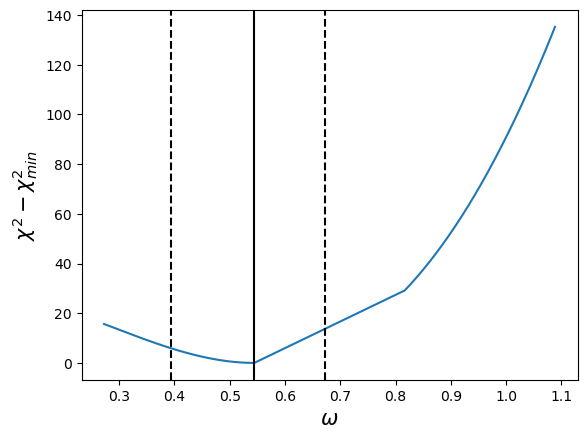

In [16]:
def Errors_ATIC(n):
    
    alpha1 = 2.79
    alpha2 = 2.62
    Eb1 = 0.275 * 1e3 #GeV
    omega1 = 0.34
    K = 4.4 * 10**(-2) #(GeV m2 s sr)-1
    bounds_range = ((4e-2,5e-2),(2,3),(2,3),(0.0001,1),(1e2,1e5))
    output = minimize(Chi_ATIC, (K, alpha1, alpha2, omega1, Eb1), method='L-BFGS-B', bounds=bounds_range)
    best_fit_values = output['x']
    
    scan = np.zeros(1000)
    fit = best_fit_values[n]
    for i in range(0, 500):
        scan[i] = fit - (fit / 1000)*i
    for j in range(500, 1000):
        scan[j] = fit + (fit / 1000)*j
    scan = np.sort(scan)
    
    true_best_fit = Chi_ATIC(best_fit_values)
    chi_sqrd = np.zeros(1000)
    for k in range(0, 1000):
        best_fit_values[n] = scan[k]
        scan_chi = Chi_ATIC(best_fit_values)
        chi_sqrd[k] = np.abs(true_best_fit - scan_chi)
    return scan, fit, chi_sqrd

# Error of width
scan, fit, chi_sqrd = Errors_ATIC(3)
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(scan, yreduced, s=0)
scan_interval = freduced.roots()
print('omega1'); print('Lower error:', fit - scan_interval[0]); print('Upper error:', scan_interval[1] - fit)

# Check chi^2 - chi^2_min distribution
plt.plot(scan, chi_sqrd)
plt.xlabel(r'$\omega$', fontsize=15)
plt.ylabel(r'$\chi^2 - \chi^2_{min}$', fontsize=15)
plt.axvline(x = fit, color='black')
plt.axvline(x = scan_interval[0], linestyle='--', color='black')
plt.axvline(x = scan_interval[1], linestyle='--', color='black')

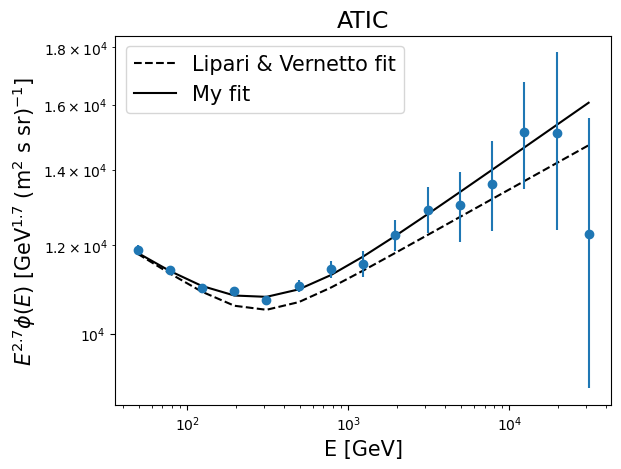

In [17]:
# Lipari & Vernetto
Phi_model = Phi_onebreak(E, K_bestfit_ATIC, 0.1 * 1e3, alpha1_bestfit_ATIC, alpha2_bestfit_ATIC, omega1_bestfit_ATIC, Eb1_bestfit_ATIC)
# Me
Phi_fit = Phi_onebreak(E, best_fit_values[0], 0.1 * 1e3, best_fit_values[1], best_fit_values[2], best_fit_values[3], best_fit_values[4])

plt.figure()
plt.plot(E, Phi_model * E**2.7, linestyle='--', color='black', label='Lipari & Vernetto fit')
plt.plot(E, Phi_fit * E**2.7, color='black', label='My fit')
plt.errorbar(E_ATIC[index], flux_ATIC[index] * E_ATIC[index]**2.7, yerr=error_ATIC[index] * E_ATIC[index]**2.7, fmt='o')
plt.loglog()
plt.ylabel(r'$E^{2.7}\phi(E)$ [GeV$^{1.7}$ (m$^2$ s sr)$^{-1}$]', fontsize=15)
plt.xlabel('E [GeV]', fontsize=15)
plt.title('ATIC', fontsize=17)
plt.legend(fontsize=15)
plt.savefig('Fits/ATIC_fit.png')